In [8]:
# --------------------
# Imports and Setup
# --------------------

import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dataclasses import dataclass
from typing import List, Dict
from src.sims.brownian import simulate_gbm
from src.sims.ou import simulate_ou
from src.strategies.mean_reversion import MeanReversionStrategy
from src.strategies.momentum import MomentumStrategy
from src.backtest import Backtest
from src.metrics import calculate_all_metrics

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)

Running backtest for MeanReversionStrategy...
Backtest complete. Final equity: $100,000.00
Running backtest for MomentumStrategy...
Backtest complete. Final equity: $99,224.10


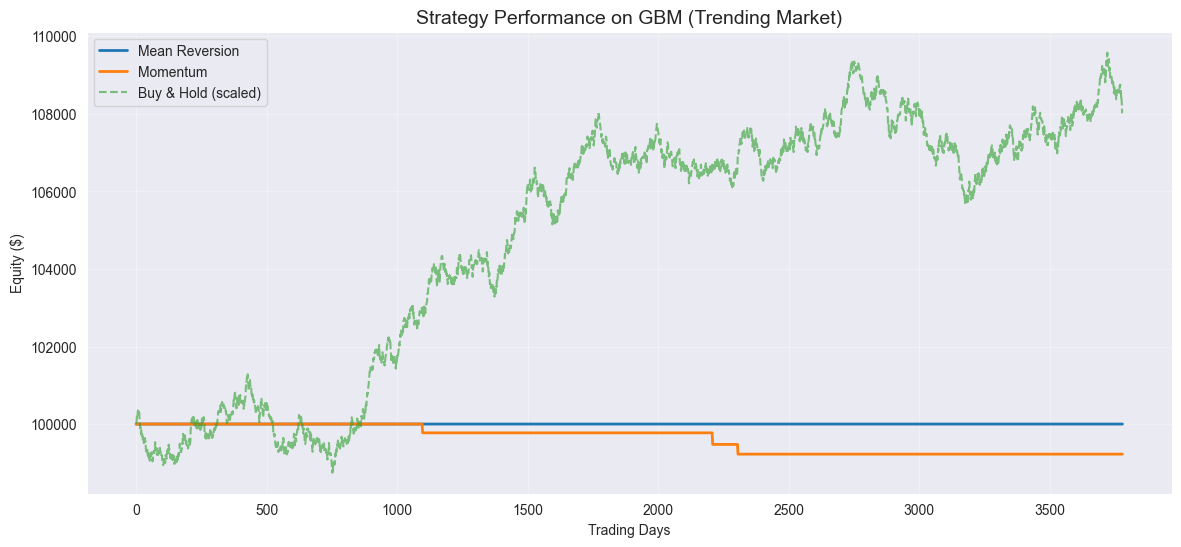

                       Mean Reversion  Momentum
Total Return                      0.0     -0.78
Annualized Return                 0.0     -0.05
Annualized Volatility             0.0      0.08
Sharpe Ratio                      0.0    -24.41
Maximum Drawdown                  0.0     -0.78
Calmar Ratio                      0.0     -0.07
Win Rate                          0.0      0.00
Total Trades                      0.0      6.00
Final Equity                 100000.0  99224.10


In [3]:
# Generate trending data
gbm_data = simulate_gbm(mu=0.05, sigma=0.20, years=15, seed=42)

# Backtest both strategies
mr_strategy = MeanReversionStrategy(window=20, entry_z=2.0, exit_z=0.5)
mom_strategy = MomentumStrategy(fast_ma=20, slow_ma=50, exit_ma=10)

mr_backtest = Backtest(mr_strategy, gbm_data)
mom_backtest = Backtest(mom_strategy, gbm_data)

mr_portfolio = mr_backtest.run()
mom_portfolio = mom_backtest.run()

# Calculate metrics
mr_metrics = calculate_all_metrics(mr_portfolio)
mom_metrics = calculate_all_metrics(mom_portfolio)

# Plot equity curves
plt.figure(figsize=(14, 6))
plt.plot(mr_portfolio.get_equity_curve()['equity'], label='Mean Reversion', linewidth=2)
plt.plot(mom_portfolio.get_equity_curve()['equity'], label='Momentum', linewidth=2)
plt.plot(gbm_data['close'] * 1000, label='Buy & Hold (scaled)', linewidth=1.5, alpha=0.6, linestyle='--')
plt.title('Strategy Performance on GBM (Trending Market)', fontsize=14)
plt.xlabel('Trading Days')
plt.ylabel('Equity ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print metrics
metrics_df = pd.DataFrame({'Mean Reversion': mr_metrics, 'Momentum': mom_metrics})
print(metrics_df.round(2))

Running backtest for MeanReversionStrategy...
Backtest complete. Final equity: $108,537.07
Running backtest for MomentumStrategy...
Backtest complete. Final equity: $99,302.65


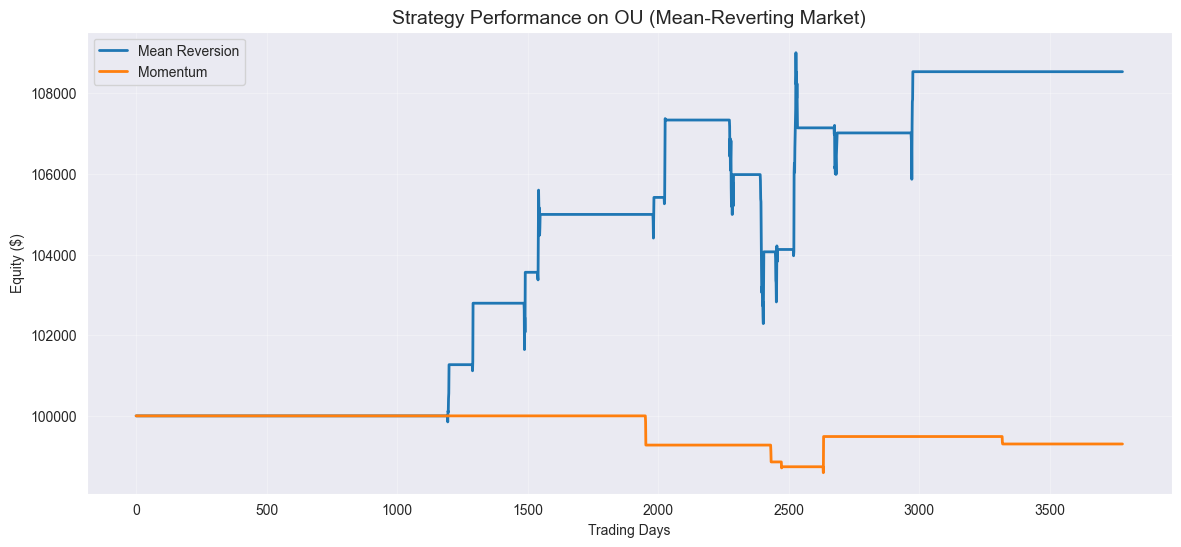

                       Mean Reversion  Momentum
Total Return                     8.54     -0.70
Annualized Return                0.55     -0.05
Annualized Volatility            1.53      0.30
Sharpe Ratio                    -0.95     -6.82
Maximum Drawdown                -4.74     -1.41
Calmar Ratio                     0.12     -0.03
Win Rate                        83.33     60.00
Total Trades                    24.00     10.00
Final Equity                108537.07  99302.65


In [4]:
# Generate mean-reverting data
ou_data = simulate_ou(theta=0.10, sigma=0.10, mean_level=np.log(100), years=15, seed=42)

# Backtest both strategies
mr_strategy = MeanReversionStrategy(window=20, entry_z=2.0, exit_z=0.5)
mom_strategy = MomentumStrategy(fast_ma=20, slow_ma=50, exit_ma=10)

mr_backtest = Backtest(mr_strategy, ou_data)
mom_backtest = Backtest(mom_strategy, ou_data)

mr_portfolio = mr_backtest.run()
mom_portfolio = mom_backtest.run()

# Calculate metrics
mr_metrics = calculate_all_metrics(mr_portfolio)
mom_metrics = calculate_all_metrics(mom_portfolio)

# Plot equity curves
plt.figure(figsize=(14, 6))
plt.plot(mr_portfolio.get_equity_curve()['equity'], label='Mean Reversion', linewidth=2)
plt.plot(mom_portfolio.get_equity_curve()['equity'], label='Momentum', linewidth=2)
plt.title('Strategy Performance on OU (Mean-Reverting Market)', fontsize=14)
plt.xlabel('Trading Days')
plt.ylabel('Equity ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print metrics
metrics_df = pd.DataFrame({'Mean Reversion': mr_metrics, 'Momentum': mom_metrics})
print(metrics_df.round(2))

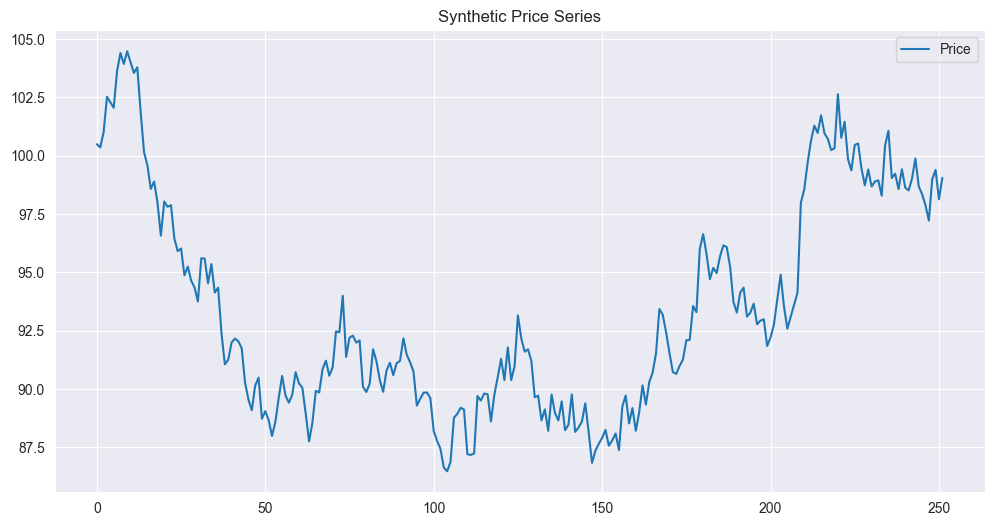

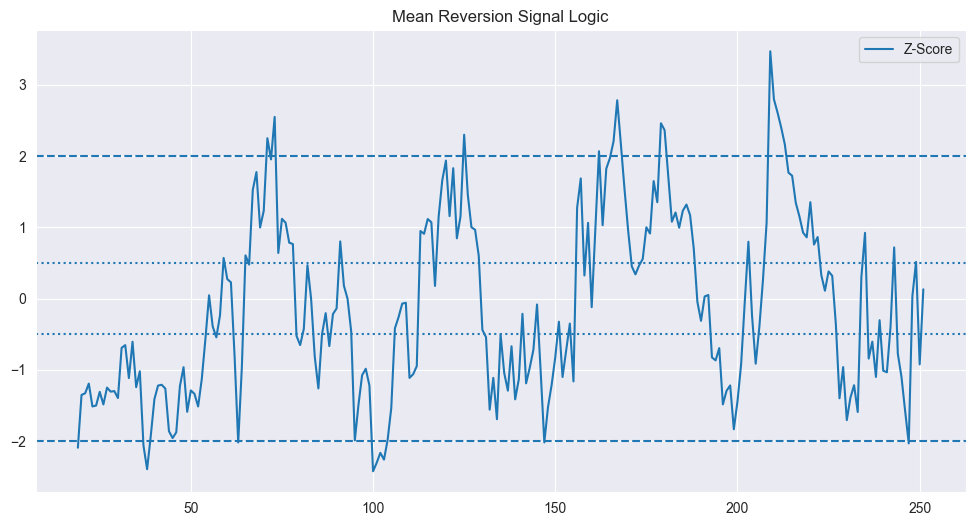

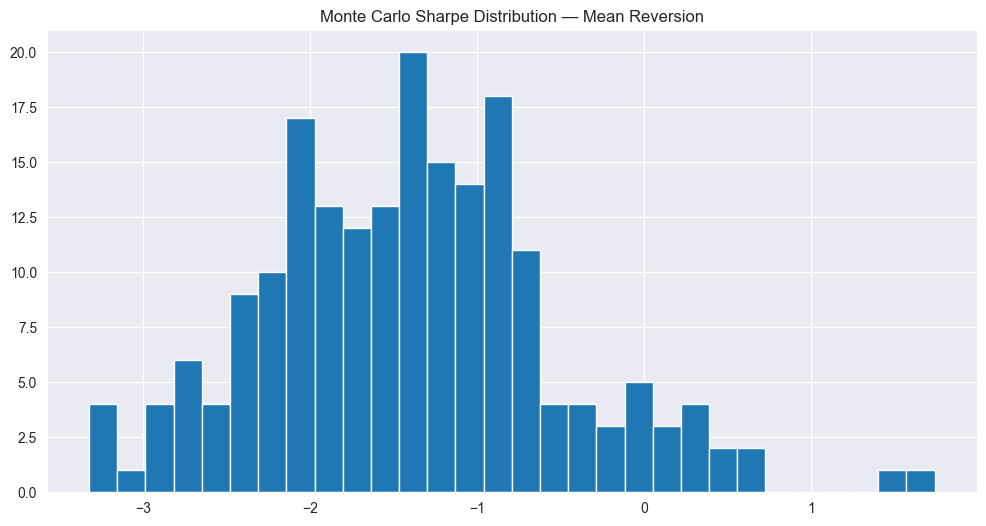

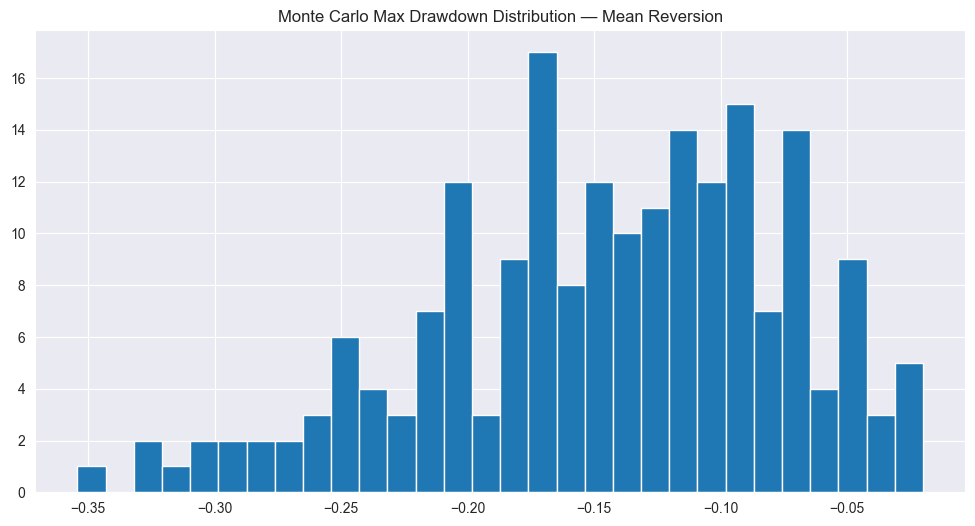

,Mean Reversion,Momentum
Sharpe,-1.689747,0.392148
Max DD,-0.117433,-0.064994
Trades,5.000000,33.000000
Win Rate,0.800000,0.424242
Avg Win,0.015686,0.007856
Avg Loss,-0.062750,-0.008258


In [10]:
# ------------------
# Expanded Analysis
# ------------------

plt.rcParams['figure.figsize'] = (12, 6)

np.random.seed(42)
price = pd.Series(np.cumsum(np.random.normal(0, 1, 252)) + 100)

def mean_reversion_signals(price: pd.Series, window=20):
    mu = price.rolling(window).mean()
    sigma = price.rolling(window).std()
    z = (price - mu) / sigma
    
    long_entries = z < -2
    short_entries = z > 2
    exits = z.abs() < 0.5
    stop = z.abs() > 3

    return z, long_entries, short_entries, exits, stop

def momentum_signals(price: pd.Series, fast=20, slow=50, exit=10):
    ma_fast = price.rolling(fast).mean()
    ma_slow = price.rolling(slow).mean()
    ma_exit = price.rolling(exit).mean()

    entries = ma_fast > ma_slow
    exits = ma_fast < ma_exit

    return ma_fast, ma_slow, ma_exit, entries, exits


z, le, se, ex, stop = mean_reversion_signals(price)

plt.plot(price, label="Price")
plt.title("Synthetic Price Series")
plt.legend()
plt.show()

plt.plot(z, label="Z-Score")
plt.axhline(2, linestyle='--')
plt.axhline(-2, linestyle='--')
plt.axhline(0.5, linestyle=':')
plt.axhline(-0.5, linestyle=':')
plt.title("Mean Reversion Signal Logic")
plt.legend()
plt.show()

@dataclass
class BacktestResult:
    returns: pd.Series
    trades: int
    win_rate: float
    avg_win: float
    avg_loss: float
    sharpe: float
    max_dd: float


def compute_metrics(returns: pd.Series) -> Dict:
    if returns.std() == 0:
        sharpe = 0
    else:
        sharpe = np.sqrt(252) * returns.mean() / returns.std()

    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak

    return sharpe, drawdown.min()

def backtest_long_only(price: pd.Series, entries: pd.Series, exits: pd.Series, cost=0.0005):
    position = 0
    returns = []
    trade_returns = []

    for i in range(1, len(price)):
        if entries.iloc[i] and position == 0:
            position = 1
            entry_price = price.iloc[i]

        elif exits.iloc[i] and position == 1:
            ret = (price.iloc[i] - entry_price) / entry_price - cost
            trade_returns.append(ret)
            position = 0

        if position == 1:
            returns.append((price.iloc[i] - price.iloc[i-1]) / price.iloc[i-1])
        else:
            returns.append(0)

    returns = pd.Series(returns)

    wins = [r for r in trade_returns if r > 0]
    losses = [r for r in trade_returns if r <= 0]

    win_rate = len(wins) / len(trade_returns) if trade_returns else 0
    avg_win = np.mean(wins) if wins else 0
    avg_loss = np.mean(losses) if losses else 0

    sharpe, max_dd = compute_metrics(returns)

    return BacktestResult(returns, len(trade_returns), win_rate, avg_win, avg_loss, sharpe, max_dd)

ma_fast, ma_slow, ma_exit, mom_entries, mom_exits = momentum_signals(price)
mr_result = backtest_long_only(price, le, ex)
mom_result = backtest_long_only(price, mom_entries, mom_exits)

mr_result, mom_result

def monte_carlo_backtest(simulator, strategy_func, runs=250):
    sharpes = []
    drawdowns = []

    for _ in range(runs):
        price = simulator()
        entries, exits = strategy_func(price)
        result = backtest_long_only(price, entries, exits)
        sharpes.append(result.sharpe)
        drawdowns.append(result.max_dd)

    return np.array(sharpes), np.array(drawdowns)

def simple_gbm_sim(n=252, mu=0.07, sigma=0.2):
    dt = 1/252
    returns = np.random.normal((mu - 0.5 * sigma**2) * dt, sigma * np.sqrt(dt), n)
    return pd.Series(100 * np.exp(np.cumsum(returns)))

def mr_strategy(price):
    z, le, se, ex, stop = mean_reversion_signals(price)
    return le, ex

sharpes, dds = monte_carlo_backtest(simple_gbm_sim, mr_strategy, runs=200)

plt.hist(sharpes, bins=30)
plt.title("Monte Carlo Sharpe Distribution — Mean Reversion")
plt.show()

plt.hist(dds, bins=30)
plt.title("Monte Carlo Max Drawdown Distribution — Mean Reversion")
plt.show()


def summarize(result: BacktestResult):
    return pd.Series({
        "Sharpe": result.sharpe,
        "Max DD": result.max_dd,
        "Trades": result.trades,
        "Win Rate": result.win_rate,
        "Avg Win": result.avg_win,
        "Avg Loss": result.avg_loss
    })

summary = pd.DataFrame({
    "Mean Reversion": summarize(mr_result),
    "Momentum": summarize(mom_result)
})

summary